In [1]:
import numpy as np
import thewalrus as tw
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
N = 4
D = 20

def gen_S(cov):
    from scipy.linalg import block_diag
    from strawberryfields.decompositions import williamson
    Ss = []
    Svs = []
    N = cov.shape[0]//2
    for i in range(N):
        sub_cov = cov[[i,i+N],:][:,[i,i+N]]
        db, S = williamson(sub_cov)
        Ss.append(S)
        Svs.append(db[0,0])
    return block_diag(*Ss)[[i for i in range(0,2*N,2)]+[i for i in range(1,2*N,2)],:][:,[i for i in range(0,2*N,2)]+[i for i in range(1,2*N,2)]], Svs

In [3]:
specWs = []
SDsums = []

for i in tqdm(range(100)): #<-- increase this for more samples
    cov = tw.random.random_covariance(N,hbar=1,pure=True)
    S, Svs = gen_S(cov)
    cov = np.linalg.inv(S)@cov@np.linalg.inv(S.T)
    SFstate = tw.quantum.state_vector(np.zeros(2*N),cov,cutoff=D,hbar=1)
    specWs.append(np.real(np.vdot(SFstate,SFstate)))

    SD = np.asarray([[nbar**n/(nbar+1)**(n+1) for n in range(D)] for nbar in np.asarray(Svs)-0.5])
    SDsum = SD.sum()
    SDsums.append(SDsum/N)

100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


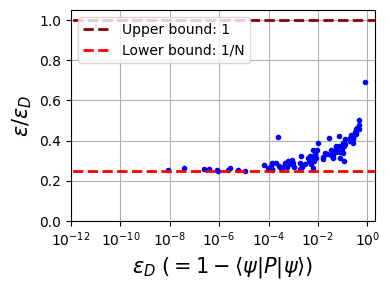

In [4]:
plt.figure(figsize=(4,3))
plt.plot(1-np.array(specWs),(1-np.array(SDsums))/((1-np.array(specWs))),'b.',alpha=1)
plt.hlines([1],0,2,ls="--",color="darkred",lw=2,zorder=2,label="Upper bound: 1")
plt.hlines([1/4],0,2,ls="--",color="red",lw=2,zorder=3,label="Lower bound: 1/N")

plt.xscale("log")

plt.xlabel(r"$\varepsilon_D$ $(= 1-\langle\psi|P|\psi\rangle)$",fontsize=15)
plt.ylabel(r"$\varepsilon / \varepsilon_D$",fontsize=15)
plt.grid()
plt.ylim(-0.0,1.05)
plt.xlim(1e-12,2)
plt.tight_layout()
plt.legend(loc='upper left')